# Kelvin Abrokwa-Johnson

## Note:
#### 0. Rename this file to PA1yourLastName, e.g. PA1Chung, and work directly on it.
#### 1. Due on 11:59 PM on Monday 3/14.
#### 2. You may NOT use the backslash operator in Julia to solve the linear system, (A\b).  
#### 3. You are encouraged to use codes from Lab.  
#### 4. Indivisual work.  Copying in any form is a violation of the Honor code.
#### 5. Present your answers and results in the TEXT environment and in complete sentences.

## Problem 1 (50 pts) 
In class, we go over how to formulate linear boundary value problems as linear system problems, and you may find the full discussion in Section 11.3.  In this problem, you need to implement ```LinearBVPsolver```. <br>
1a. Test your solver for Example 1 on page 688, and problem #2 in on page 689. <br>
1b. Do problem #8 in Section 11.3 on page 690.

In [186]:
using PyPlot

In [187]:
#
# @param a <number> endpoint
# @param b <number> endpoint
# @param alpha <number> boundary condition
# @param beta <number> boundary condition
# @param p <function>
# @param q <function>
# @param r <function>
# @param h <function>
# @param N <number>
#
function LinearBVPsolver(a, b, alpha, beta, p, q, r, h, N)
    _a = zeros(N,1)
    _b = zeros(N,1)
    _c = zeros(N,1)
    _d = zeros(N,1)
    
    # step 1
    h = (b-a) / (N+1)
    x = a + h
    _a[1] = 2 + h^2 * q(x)
    _b[1] = -1 + (h/2) * p(x)
    _d[1] = -(h^2 * r(x)) + (1 + (h/2) * p(x)) * alpha
    
    # step 2
    for i = 2:N-1
        x = a + i*h
        _a[i] = 2 + h^2 * q(x)
        _b[i] = -1 + (h/2) * p(x)
        _c[i] = -1 - (h/2) * p(x)
        _d[i] = -(h^2) * r(x)
    end
    
    # step 3
    x = b - h
    _a[N] = 2 + h^2 * q(x)
    _c[N] = -1 - (h/2) * p(x)
    _d[N] = -(h^2) * r(x) + (1 - (h/2) * p(x)) * beta
    
    # Tridiagonal solver
    l = zeros(N,1)
    u = zeros(N,1)
    z = zeros(N,1)
    w = zeros(N+1,1)
    
    # step 4
    l[1] = _a[1]
    u[1] = _b[1]/_a[1]
    z[1] = _d[1]/l[1]
    
    # step 5
    for i = 2:N-1
        l[i] = _a[i] - _c[i]*u[i-1]
        u[i] = _b[i]/l[i]
        z[i] = (_d[i] - _c[i]*z[i-1]) / l[i]
    end
    
    # step 6
    l[N] = _a[N] - _c[N]*u[N-1]
    z[N] = (_d[N] - _c[N]*z[N-1]) / l[N]
    
    # step 7
    w[1] = alpha
    w[N+1] = beta
    w[N] = z[N]
    
    # step 8
    for i = N-1:-1:1
        w[i] = z[i] - u[i]*w[i+1]
    end
    
    x = zeros(N+1)
    # step 9
    for i = 1:N+1
        x[i] = a + i*h
    end
    
    return x, w
end

LinearBVPsolver (generic function with 1 method)

## 1a. - example 1

[1

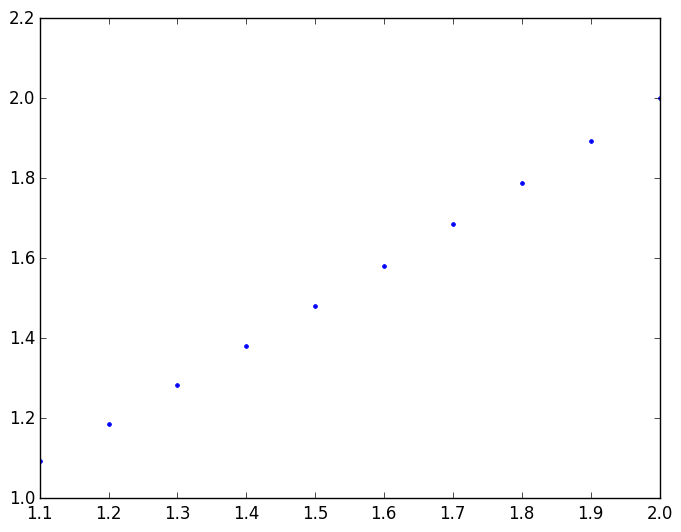

.092600520720135
 1.1870431287950733
 1.283336870214396
 1.3814020462286076
 1.4811202621122188
 1.5823598956934566
 1.6849890183845613
 1.7888817461937456
 1.893921099157133
 2.0]


In [212]:
a = 1
b = 2
alpha = 1
beta = 2
p = x -> -2/x
q = x -> 2/x^2
r = x -> sin(log(x))/x^2
h = 0.1
N = 9
x, w = LinearBVPsolver(a, b, alpha, beta, p, q, r, h, N)
plot(x, w, ".")
println(w)

[-

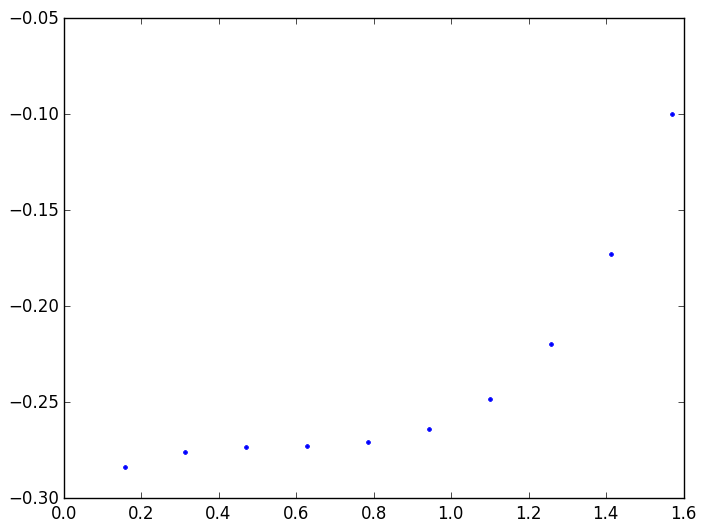

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31f4b54d0>

0.28385431398378286
 -0.2759690226404903
 -0.27324425597248503
 -0.2725318297793264
 -0.2705539981844183
 -0.2637940468825499
 -0.24834589548313704
 -0.2197057296820073
 -0.172482967701722
 -0.1]


In [213]:
# 1a - #2 page 689
a = 0
b = pi/2
alpha = -0.3
beta = -0.1
p = x -> 1
q = x -> 2
r = x -> sin(x)

# a
h = pi/4
N = 9
x, w = LinearBVPsolver(a, b, alpha, beta, p, q, r, h, N)
println(w)
plot(x, w, ".")

## b.

0.28385431398378286
 -0.2759690226404903
 -0.27324425597248503
 -0.2725318297793264
 -0.2705539981844183
 -0.2637940468825499
 -0.24834589548313704
 -0.2197057296820073
 -0.172482967701722
 -0.1]
[-

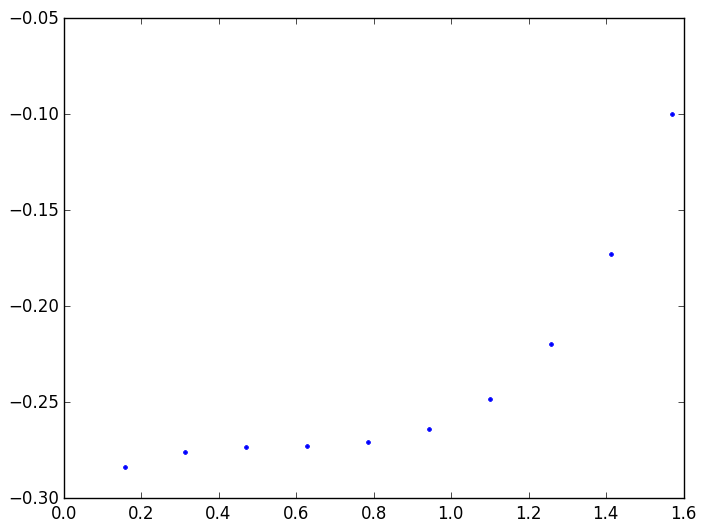

In [190]:
h = pi/8
N = 9
x, w = LinearBVPsolver(a, b, alpha, beta, p, q, r, h, N)
plot(x, w, ".")
println(w)

## 1b - page 690, #8

0.28385431398378286
 -0.2759690226404903
 -0.27324425597248503
 -0.2725318297793264
 -0.2705539981844183
 -0.2637940468825499
 -0.24834589548313704
 -0.2197057296820073
 -0.172482967701722
 -0.1]
[8

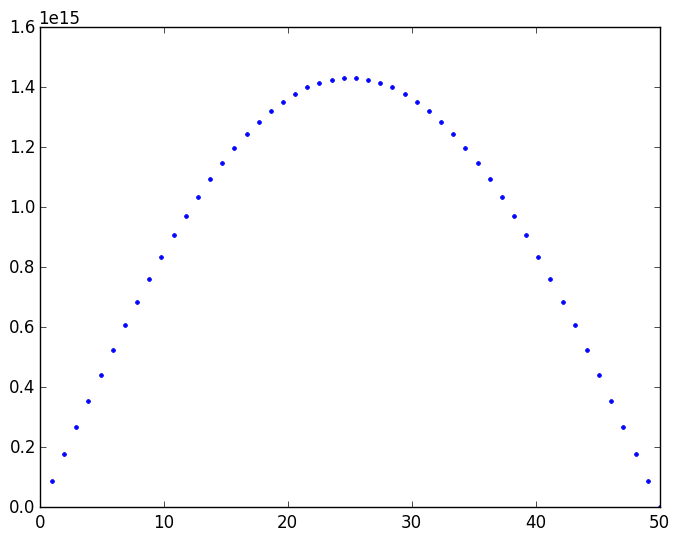

In [191]:
# problem params
S = 100 # 100lbs/in
Q = 200 # 200lbs/in^2
D = 8.8e7# 8.8 * 10^7
l = 50

# function arguments
a = 0
b = 50
alpha = 0
beta = 0
p = x -> 0
q = x -> S/D
r = x -> (Q/2*D)*x^2 - (Q*l/2*D)*x
h = 1
N = 50
x, w = LinearBVPsolver(a, b, alpha, beta, p, q, r, h, N)
plot(x, w, ".")
println(w)

# Problem 2 (50 pts)
CG method only works for SPD matrices. The biconjugate gradient stabilized method (BiCGSTAB) is designed for general matrices (see the original paper http://epubs.siam.org/doi/abs/10.1137/0913035 for details if interested). In this problem, you are going to implement BiCGSTAB.  

To solve a linear system Ax = b, BiCGSTAB starts with an initial guess $x_0$ and proceeds as follows:
* $r_0 = b − Ax_0$
* Choose an arbitrary vector $\hat{r}_0$ such that $(\hat{r}_0, r_0) \ne 0$, e.g., $\hat{r}_0 = r_0$.
* $\rho_0 = \alpha = \omega_0 = 1$
* $v_0 = p_0 = 0$
* For i = 1, 2, 3, …
  * $\rho_i = (\hat{r}_0, r_{i−1})$
  * $\beta = (\rho_i/\rho_{i−1})(\alpha/\omega_{i−1})$
  * $p_i = r_{i−1} + \beta(p_{i−1} − \omega_{i−1}v_{i−1})$
  * $v_i = Ap_i$
  * $\alpha = \rho_i/(\hat{r}_0, v_i)$
  * $s = r_{i−1} − \alpha v_i$
  * if $\|s\|_{\infty}$ sufficiently small, then set $x_i = x_{i−1} + \alpha p_i$ and quit
  * $t = As$
  * $\omega_i = (t, s)/(t, t)$
  * $x_i = x_{i−1} + \alpha p_i + \omega_i s$
  * $r_i = s − \omega_i t$
  
>  $(u, v)$ means dot product of vector u and v. The algorithm is from https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method

Do the following: <br>
2a. Implement BiCGSTAB and test it for #4ab in Section 6.1 on page 368. <br>
2b. Use BiCGSTAB with TOL=1e-8 to solve the system $Ax = b$, where $A$ is defined as 
<img src="PA1Prob2Mat.png">
and $b=(1, 0, 0, ..., 0)$, and $n=101$ (the code for creating this matrix is given).   <br>
2c. Use SOR with TOL=1e-8 and w=1.9 to solve the same system. Compare number of iterations required in 2b and 2c.  What do you observe?

> Note that the matrix is NOT tridiagonal, nor SPD.

In [204]:
function BiCGSTAB(A, b, x, TOL)
    n, n1 = size(A)
    r = b[:] - A[:,:]*x[:]
    r_hat = r[:]
    rho = alpha = omega = 1
    v = 0
    p = 0
    _r = zeros(n)
    for i=1:n
        _rho = rho
        _r[1:n] = r[1:n]
        rho = dot(r_hat, _r)
        beta = (rho/_rho) * (alpha/omega)
        p = _r + beta * (p - (omega * v))
        v = A * p
        alpha = rho / dot(r_hat, v)
        s = _r - alpha*v
        if norm(s, Inf) < TOL
            return x + alpha*p
        end
        t = A*s
        omega = dot(t,s) / dot(t,t)
        x = x + alpha*p + omega*s
        r = s - omega*t
    end
    return x + alpha*p
end

BiCGSTAB (generic function with 1 method)

## 2a.

In [205]:
# Section 6.1 on page 368a
A = [
    -1 4 1;
    5/3 2/3 2/3;
    2 1 4
]
b = [8.0; 1; 11]
x = [0.0; 0; 0]
TOL = 1e-8
BiCGSTAB(A, b, x, TOL)

3-element Array{Float64,1}:
 -1.0
  1.0
  3.0

In [206]:
# Section 6.1 on page 368b
A = [
    4 2 -1;
    1/9 1/9 -1/3;
    1 4 2;
]
b = [-5.0; -1; 9]
x = [0.0; 0; 0]
TOL = 1e-8
BiCGSTAB(A, b, x, TOL)

3-element Array{Float64,1}:
 -1.0
  1.0
  3.0

In [207]:
function genTriDiag(n, l, d, r)
    #generate a tridiagonal matrix of size n by n with entries l, d, r.
    T = zeros(n,n)
    for i = 1:n
        T[i,i] = d
        if i+1 <= n
            T[i, i+1] = r
        end
        if i-1 >= 1
            T[i, i-1] = l
        end
    end
    return T
end

genTriDiag (generic function with 1 method)

## 2b.

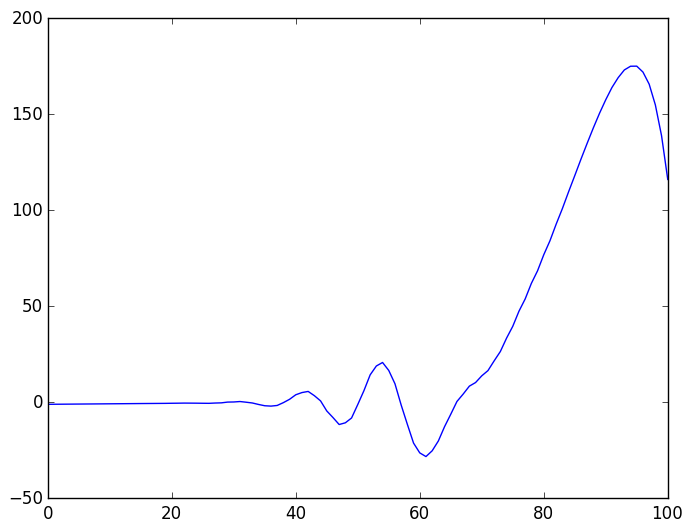

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320586150>

In [208]:
A = zeros(101,101)
A[1:100,1:100] = genTriDiag(100, 1, -2, 1)
A[100, 101] = 1
A[101, 1] = 4
A[101, 2] = -1.0
g = 0.1
A[101, 99] = g
A[101,100] = -4*g
A[101,101] = 3*g
b = zeros(101)
b[1] = 1
sol = BiCGSTAB(A, b, zeros(101), 1e-8)
plot(sol)

## 2c.

In [199]:
function SOR(A, b, x0, w, TOL, Nmax)
    n, n1 = size(A)
    x = zeros(n,1)
    for k = 1:Nmax
        for i = 1:n
            temp1 = 0
            for j = 1:i-1
                temp1 = temp1 + A[i,j] * x[j]
            end
            
            temp2 = 0
            for j = i+1:n
                temp2 = temp2 + A[i,j] * x0[j]
            end
            
            x[i] = (1 - w)*x0[i] + (w/A[i,i])*((-temp1) - temp2 + b[i])
        end
        res = norm(x - x0, Inf) # make sure calculating inf norm
        if res < TOL
            println("iterations: ", k)
            return x
        end
        x0[1:n] = x[1:n]
    end
    println("Reach the maximum iterations! Solution might be wrong")
end

SOR (generic function with 1 method)

In [198]:
A = zeros(101,101)
A[1:100,1:100] = genTriDiag(100, 1, -2, 1)
A[100, 101] = 1
A[101, 1] = 4
A[101, 2] = -1.0
g = 0.1
A[101, 99] = g
A[101,100] = -4*g
A[101,101] = 3*g
b = zeros(101)
b[1] = 1
SOR(A, b, zeros(101), 1.9, 1e-8, 10000)

Reach the maximum iterations! Solution might be wrong


BiCGSTAB take all 100 iterations but the SOR method does not reach a solution after 10000 iterations.